In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49) 
[GCC 7.5.0]
3.0.1


In [1]:
import pandas as pd
import numpy as np

/Users/gracechai/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
t=pd.DataFrame({'a':[1,2,3,4,5,6,7,8,9,10],'b':[1,2,3,4,5,6,7,8,9,10] })


a   b
0   1   1
1   2   2
2   3   3
3   4   4
4   5   5
5   6   6
6   7   7
7   8   8
8   9   9
9  10  10

In [4]:
t['0.3']=['dup'*3, 'nondup'*7]

ValueError: Length of values (2) does not match length of index (10)

In [2]:
import tqdm
from itertools import combinations, takewhile
from simhash import Simhash, SimhashIndex
import collections
import io
import re

In [1]:
import pandas as pd
import numpy as np
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [4]:
#Read the data
directory = 'gs://msca-bdp-tweets/Tweets/'
file = '*.json'
path = directory + file

In [ ]:
df = spark.read.json(path)

In [ ]:
df

+------------+-----------+--------------------+------------------+--------------------+--------------------+--------------------+--------------+---------+------------+----+------------------+------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+-----+------------------+-----------+--------------------+------------------+--------------------+-----------------------+-----------+-------------+---------+--------------------+------+--------------------+--------------------+-------------+---------+--------------------+------------------+---------------------+
|contributors|coordinates|          created_at|display_text_range|            entities|   extended_entities|      extended_tweet|favorite_count|favorited|filter_level| geo|                id|            id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|limit|place|possibly_sensitive|quote_count|       quoted_status|  quoted_status_id|quoted_status_id_str|quoted_status_permalink|reply_count|retweet_count|retweeted|    retweeted_status|scopes|              source|                text| timestamp_ms|truncated|                user|withheld_copyright|withheld_in_countries|
+------------+-----------+--------------------+------------------+--------------------+--------------------+--------------------+--------------+---------+------------+----+------------------+------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+-----+------------------+-----------+--------------------+------------------+--------------------+-----------------------+-----------+-------------+---------+--------------------+------+--------------------+--------------------+-------------+---------+--------------------+------------------+---------------------+
|        null|       null|Thu Jun 22 23:16:...|              null|[[], [[,, pic.twi...|[[[,, pic.twitter...|                null|             0|    false|         low|null|878028835710619648|878028835710619648|                   null|                 null|                     null|               null|                   null|          false|  en| null| null|             false|       null|                null|              null|                null|                   null|       null|            0|    false|[,, Wed Jun 14 18...|  null|<a href="http://t...|RT @millselle: my...|1498173362077|    false|[false, Sat Nov 3...|              null|                 null|
|        null|       null|Thu Jun 22 23:16:...|           [0, 19]|[[],, [], [[twitt...|                null|                null|             0|    false|         low|null|878028835832209410|878028835832209410|                   null|                 null|                     null|               null|                   null|           true|  en| null| null|             false|       null|[,, Thu Jun 22 22...|878021691875536896|  878021691875536896|                   null|       null|            0|    false|                null|  null|<a href="http://t...|You clean up nice...|1498173362106|    false|[false, Thu May 2...|              null|                 null|
|        null|       null|Thu Jun 22 23:16:...|              null|[[],, [], [], [[2...|                null|                null|             0|    false|         low|null|878028837845696512|878028837845696512|                   null|                 null|                     null|               null|                   null|          false|  en| null| null|              null|       null|                null|              null|                null|                   null|       null|            0|    false|[,, Thu Jun 22 21...|  null|<a href="http://t...|RT @ACEPNow: Mike...|1498173362586|    false|[false, Tue May 0...|              null|               

In [ ]:
df.columns

['contributors',
 'coordinates',
 'created_at',
 'display_text_range',
 'entities',
 'extended_entities',
 'extended_tweet',
 'favorite_count',
 'favorited',
 'filter_level',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'limit',
 'place',
 'possibly_sensitive',
 'quote_count',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'quoted_status_permalink',
 'reply_count',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'scopes',
 'source',
 'text',
 'timestamp_ms',
 'truncated',
 'user',
 'withheld_copyright',
 'withheld_in_countries']

In [ ]:
df.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |-- monetizable: bo

## Columns for User Analysis:
user.id,
user.name,
user.location,
user.verified,
user.followers_count,
user.friends_count,
user.listed_count,
user.favourites_count,
user.statuses_count,
retweeted_status.user.statuses_count
## Columns for Tweet Analysis:
created_at,
place.country,
place.name,
place.full_name,
retweeted_status.retweet_count,
retweeted_status.favorite_count,
retweeted_status.reply_count,
retweeted_status.quote_count,
quote_count,
filter_level,
extended_tweet.full_text,
text

In [ ]:
## filter the columns I chose
df1=df.selectExpr('user.id as userid','user.name as username','user.location as userlocation',"user.verified as verified","user.followers_count as userfollowers_count",'user.friends_count as userfriends_count',
                  'user.listed_count as userlisted_count','user.favourites_count as userfavor_count','user.statuses_count as userstat_count', 
                  'created_at',"place.country as country", "place.name as palcename","place.full_name as place_fullname","retweeted_status.user.statuses_count",
                  "retweeted_status.retweet_count",'retweeted_status.favorite_count','retweeted_status.reply_count','retweeted_status.quote_count', "quote_count as text_quote_count",
 'filter_level','extended_tweet.full_text as fulltxt','text')

In [ ]:
df1.show(10)

+------------------+--------------------+---------------+--------+-------------------+-----------------+----------------+---------------+--------------+--------------------+-------+---------+--------------+--------------+-------------+--------------+-----------+-----------+----------------+------------+--------------------+--------------------+
|            userid|            username|   userlocation|verified|userfollowers_count|userfriends_count|userlisted_count|userfavor_count|userstat_count|          created_at|country|palcename|place_fullname|statuses_count|retweet_count|favorite_count|reply_count|quote_count|text_quote_count|filter_level|             fulltxt|                text|
+------------------+--------------------+---------------+--------+-------------------+-----------------+----------------+---------------+--------------+--------------------+-------+---------+--------------+--------------+-------------+--------------+-----------+-----------+----------------+------------+--

In [55]:
df1.select(['text']).take(2)

[Row(text='RT @millselle: my sister graduated from university today https://t.co/ly3fCiX1x5'),
 Row(text='You clean up nice!😜 https://t.co/U5mw1v3cLb')]

## Selecting University Keyword List
### The Universities I am choosing here are: University of Chicago, Northeastern University, University of Nebraska, and Brown University

In [ ]:
uchicago=['university of chicago','uchicago']
unebraska =  ['university of nebraska']
unortheast=['northeastern university']
brown=['brown university']

In [ ]:
from pyspark.sql import HiveContext
hc = HiveContext(sc)
import pyspark.sql.functions as psf

In [ ]:
## Filtering tweetes that contain the universities names
df_uchicago=df1.filter(psf.lower(df1.text).rlike('|'.join(uchicago)))
df_unebraska=df1.filter(psf.lower(df1.text).rlike('|'.join(unebraska)))
df_unortheast=df1.filter(psf.lower(df1.text).rlike('|'.join(unortheast)))
df_brown=df1.filter(psf.lower(df1.text).rlike('|'.join(brown)))

In [ ]:
## Take a look at the first 10 columns 
df_uchicago.select('text').take(10)

[Row(text='Non-UChicago people ignore this tweet...\nTHE IOP ISNT WORTH IT WITHOUT STEVE EDWARDS\nLONG LIVE WBEZ CHICAGO https://t.co/t5EGQGXcW0'),
 Row(text='the four uchicago dress senses: business casual (25%), unrepentant STEMlord (20%), gay ascetic (10%), seinfeld extra (45%)'),
 Row(text="Professor Bruce Cumings @bruce4korea from University of Chicago and the author of 'The Origins of the Korean War' joins us."),
 Row(text='RT @HdxAcademy: We congratulate @UChicago &amp; Pres R. Zimmer on their top rating in our Guide to Colleges: Top 150 Universities:… '),
 Row(text='Great visit from @UChicago students #PaulSereno lab! Exhibits, #histology #anagensis #dinosaurs! FUN w/… https://t.co/byatkv4uth'),
 Row(text="#thursdaythought: “Shadowing attorneys this week, I felt connected to the Center's clients and their stories.”-Emma Gardner @UChicago intern"),
 Row(text='RT @MORPaleo: Great visit from @UChicago students #PaulSereno lab! Exhibits, #histology #anagensis #dinosaurs! FUN w/… ')

In [ ]:
df_unebraska.select('text').take(10)

[Row(text='RT @_TheJoshuaMoore: University Of Nebraska!📍'),
 Row(text='RT @_TheJoshuaMoore: University Of Nebraska!📍'),
 Row(text='RT @_TheJoshuaMoore: University Of Nebraska!📍'),
 Row(text='RT @_TheJoshuaMoore: University Of Nebraska!📍'),
 Row(text='RT @IdahoBoiseGems: AA Gems had a great time touring the beautiful campus and athletic facilities of University of Nebraska today… '),
 Row(text="Yesterday's performance at the Howell theatre on the campus of the University of Nebraska, Lincoln.  Extremely prou… https://t.co/e0jYy0BNFm"),
 Row(text='RT @_TheJoshuaMoore: University Of Nebraska!📍'),
 Row(text='RT @_TheJoshuaMoore: University Of Nebraska!📍'),
 Row(text='RT @_TheJoshuaMoore: University Of Nebraska!📍'),
 Row(text='RT @NolanHakel22: Excited to announce that I will be continuing my education and baseball career at the University of Nebraska. #GBR… ')]

In [ ]:
df_unortheast.select('text').take(10)

[Row(text="Good evening Northeastern University! It's 81.8 F. Tonight: Overcast, Low: 68 F, chance of rain 20%."),
 Row(text='Super excited to say that I have committed to play volleyball at Northeastern University!! Go huskies!🐾❤️ https://t.co/KETWJpdqhD'),
 Row(text='location of northeastern university https://t.co/WPpYGSXdeK #why unemployment occurs'),
 Row(text="It's windy at Northeastern University! The wind speed is a brisk 15 miles per hour."),
 Row(text='northeastern university sex week free online girl masterbaiting porn videos https://t.co/ZOVQsnWiq2'),
 Row(text='RT @itscollegebabes: Northeastern University 📍 https://t.co/PyqbSxvGRV'),
 Row(text='Updated eclipse forecast/info for Northeastern University (https://t.co/qAxch74Eo1) https://t.co/35CfZmGOrR'),
 Row(text='northeastern university sex week free online girl masterbaiting porn videos https://t.co/53LRLvs9Il'),
 Row(text='Former Northeastern University Imam "preaching" at Boston Mosque:\n\n“Grab onto the shovel, grab o

In [ ]:
df_brown.select('text').take(10)

[Row(text='Thanks to Tyler Bird of Brown University for coming out tonight!#GettingBetter https://t.co/nchSdbgkH6'),
 Row(text='RT @BritTheHarpy: Ivy League Brown University Teaching High School Kids to Be Social Justice Warriors https://t.co/78OwvHO8n0 https://t.co/…'),
 Row(text='Princess Nokia In Conversation at Brown University https://t.co/7RrLzT8v7s'),
 Row(text='RT @kimchardashiam: Princess Nokia In Conversation at Brown University https://t.co/7RrLzT8v7s'),
 Row(text="RT @RivalsNation: Celebrating Jovan's 18th birthday with some lunch in Providence after a visit to Brown University. https://t.co/frEKltGKio"),
 Row(text='Great day with academic guys playing at Brown University. @Duuukkeee @D_mitche11 @jones_jovan @Jimmy_pg12 @DallionJohnson @Iamjordanminor'),
 Row(text='RT @RivalsNation: Great day with academic guys playing at Brown University. @Duuukkeee @D_mitche11 @jones_jovan @Jimmy_pg12 @DallionJohnson…'),
 Row(text='RT @RivalsNation: Great day with academic guys playing at

In [ ]:
#check how many data I have for each university
print('Total data for Uchicago:',df_uchicago.count() )

Total data for Uchicago: 604813


In [ ]:
print('Total data for University of nebraska:',df_unebraska.count() )

Total data for University of nebraska: 200004


In [ ]:
print('Total data for Northeastern University:',df_unortheast.count() )

Total data for Northeastern University: 90170


In [ ]:
print('Total data for brown University:',df_brown.count() )

Total data for brown University: 223311


In [ ]:
dff1=df_uchicago.toPandas()

In [ ]:
dff2=df_unebraska.toPandas()

In [ ]:
dff3=df_unortheast.toPandas()

In [ ]:
dff4=df_brown.toPandas()

In [21]:
dff1.describe()

userid  userfollowers_count  userfriends_count  userlisted_count  \
count  6.048130e+05         6.048130e+05       6.048130e+05     604813.000000   
mean   2.524329e+17         8.291244e+03       1.757997e+03        121.446151   
std    4.281705e+17         2.178991e+05       7.936335e+03       1125.848515   
min    2.210000e+02         0.000000e+00       0.000000e+00          0.000000   
25%    1.754212e+08         1.570000e+02       2.190000e+02          1.000000   
50%    1.325246e+09         5.330000e+02       5.510000e+02          9.000000   
75%    7.275337e+17         1.896000e+03       1.464000e+03         56.000000   
max    1.318023e+18         4.706463e+07       1.615588e+06     200673.000000   

       userfavor_count  userstat_count  statuses_count  retweet_count  \
count     6.048130e+05    6.048130e+05    4.085240e+05  408524.000000   
mean      2.331776e+04    4.231619e+04    4.631799e+04     581.943974   
std       5.576917e+04    1.257319e+05    1.341051e+05    1571.366305   
min       0.000000e+00    1.000000e+00    0.000000e+00       1.000000   
25%       7.430000e+02    1.594000e+03    2.558000e+03       3.000000   
50%       4.514000e+03    7.529000e+03    1.102100e+04      19.000000   
75%       2.051100e+04    2.882500e+04    3.601500e+04     249.000000   
max       1.536026e+06    7.960131e+06    3.491741e+06   12333.000000   

       favorite_count    reply_count    quote_count  text_quote_count  
count   408524.000000  395705.000000  395705.000000          582044.0  
mean      2391.246490      37.689688      79.977946               0.0  
std       7614.483678     105.291466     229.838117               0.0  
min          0.000000       0.000000       0.000000               0.0  
25%          5.000000       0.000000       0.000000               0.0  
50%         46.000000       2.000000       2.000000               0.0  
75%        704.000000      22.000000      24.000000               0.0  
max     101756.000000    1038.000000    2553.000000               0.0

In [22]:
dff1.dtypes

userid                   int64
username                object
userlocation            object
verified                  bool
userfollowers_count      int64
userfriends_count        int64
userlisted_count         int64
userfavor_count          int64
userstat_count           int64
created_at              object
country                 object
palcename               object
place_fullname          object
statuses_count         float64
retweet_count          float64
favorite_count         float64
reply_count            float64
quote_count            float64
text_quote_count       float64
filter_level            object
fulltxt                 object
text                    object
dtype: object

In [23]:
#writing all the data to csv 
dff1.to_csv('gs://msca-bdp-students-bucket/notebooks/gchai/uchicago_data1.csv', index = False)

In [24]:
dff2.to_csv('gs://msca-bdp-students-bucket/notebooks/gchai/unebraska_data1.csv', index = False)

In [25]:
dff3.to_csv('gs://msca-bdp-students-bucket/notebooks/gchai/northeast_data1.csv', index = False)

In [26]:
dff4.to_csv('gs://msca-bdp-students-bucket/notebooks/gchai/brown_data1.csv', index = False)

## Reading the New Data

In [2]:
dff_uchi=pd.read_csv('gs://msca-bigdata-1/notebooks/gchai/uchicago_data1.csv')

/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0,1,2,3,7,9,10,11,12,17,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
dff_unl=pd.read_csv('gs://msca-bigdata-1/notebooks/gchai/unebraska_data1.csv')

/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
dff_north=pd.read_csv('gs://msca-bigdata-1/notebooks/gchai/northeast_data1.csv')

/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0,1,2,3,9,10,11,12,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
dff_brown=pd.read_csv('gs://msca-bigdata-1/notebooks/gchai/brown_data1.csv')

In [10]:
dff_uchi.head(5)

userid              username        userlocation verified  \
0  7.19274e+17          Mikala Paula                 NaN    False   
1  7.37177e+17        @body_negative  hyde park, chicago    False   
2   1.0372e+08  tbs eFM This Morning  Seoul, South Korea    False   
3  8.15617e+17   Elizabeth Marquardt       United States    False   
4   8.6957e+17    MuseumoftheRockies         Bozeman, MT    False   

   userfollowers_count  userfriends_count  userlisted_count userfavor_count  \
0                420.0              390.0              54.0           10430   
1                103.0              152.0               1.0            4158   
2               1283.0              690.0              46.0             196   
3                 33.0              463.0               0.0             225   
4                293.0              243.0               7.0             156   

   userstat_count                      created_at  ...  \
0          5739.0  Thu Jun 22 23:28:13 +0000 2017  ...   
1           558.0  Thu Jun 22 23:33:37 +0000 2017  ...   
2          6150.0  Thu Jun 22 23:35:29 +0000 2017  ...   
3           101.0  Thu Jun 22 23:36:01 +0000 2017  ...   
4           120.0  Thu Jun 22 23:42:33 +0000 2017  ...   

               place_fullname statuses_count retweet_count  favorite_count  \
0                         NaN            NaN           NaN             NaN   
1                         NaN            NaN           NaN             NaN   
2  Jung-gu, Republic of Korea            NaN           NaN             NaN   
3                         NaN         1384.0           2.0             2.0   
4                         NaN            NaN           NaN             NaN   

   reply_count  quote_count  text_quote_count filter_level  \
0          NaN          NaN               NaN          low   
1          NaN          NaN               NaN          low   
2          NaN          NaN               NaN          low   
3          NaN          NaN               NaN          low   
4          NaN          NaN               NaN          low   

                                             fulltxt  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  Great visit from @UChicago students #PaulSeren...   

                                                text  
0  Non-UChicago people ignore this tweet...\nTHE ...  
1  the four uchicago dress senses: business casua...  
2  Professor Bruce Cumings @bruce4korea from Univ...  
3  RT @HdxAcademy: We congratulate @UChicago &amp...  
4  Great visit from @UChicago students #PaulSeren...  

[5 rows x 22 columns]

In [11]:
dff_uchi.dtypes

userid                  object
username                object
userlocation            object
verified                object
userfollowers_count    float64
userfriends_count      float64
userlisted_count       float64
userfavor_count         object
userstat_count         float64
created_at              object
country                 object
palcename               object
place_fullname          object
statuses_count         float64
retweet_count          float64
favorite_count         float64
reply_count            float64
quote_count             object
text_quote_count       float64
filter_level            object
fulltxt                 object
text                    object
dtype: object

### Change Some of the Columns' Data Type

In [6]:
dff_uchi['userid']=pd.to_numeric(dff_uchi.userid,errors='coerce')
dff_uchi['quote_count']=pd.to_numeric(dff_uchi.quote_count,errors='coerce')
dff_uchi['userfavor_count']=pd.to_numeric(dff_uchi.userfavor_count,errors='coerce')

dff_unl['userid']=pd.to_numeric(dff_unl.userid,errors='coerce')
dff_unl['quote_count']=pd.to_numeric(dff_unl.quote_count,errors='coerce')
dff_unl['userfavor_count']=pd.to_numeric(dff_unl.userfavor_count,errors='coerce')

dff_north['userid']=pd.to_numeric(dff_north.userid,errors='coerce')
dff_north['quote_count']=pd.to_numeric(dff_north.quote_count,errors='coerce')
dff_north['userfavor_count']=pd.to_numeric(dff_north.userfavor_count,errors='coerce')

dff_brown['userid']=pd.to_numeric(dff_brown.userid,errors='coerce')
dff_brown['quote_count']=pd.to_numeric(dff_brown.quote_count,errors='coerce')
dff_brown['userfavor_count']=pd.to_numeric(dff_brown.userfavor_count,errors='coerce')

In [13]:
dff_uchi.dtypes

userid                 float64
username                object
userlocation            object
verified                object
userfollowers_count    float64
userfriends_count      float64
userlisted_count       float64
userfavor_count        float64
userstat_count         float64
created_at              object
country                 object
palcename               object
place_fullname          object
statuses_count         float64
retweet_count          float64
favorite_count         float64
reply_count            float64
quote_count            float64
text_quote_count       float64
filter_level            object
fulltxt                 object
text                    object
dtype: object

# 1. Identify the most prolific / influential Twitterers
### 1) By message volume
* I chose to user's status_count which indicates how many tweetes(include retweets) the user created. I will pick the top 10 tweeters who have the most tweets. 
   

In [7]:
dff=pd.concat([dff_uchi, dff_north, dff_unl, dff_brown])

In [15]:
dff.head(10)

userid              username        userlocation verified  \
0  7.192744e+17          Mikala Paula                 NaN    False   
1  7.371768e+17        @body_negative  hyde park, chicago    False   
2  1.037199e+08  tbs eFM This Morning  Seoul, South Korea    False   
3  8.156170e+17   Elizabeth Marquardt       United States    False   
4  8.695699e+17    MuseumoftheRockies         Bozeman, MT    False   
5  1.866377e+08   Harriett Buhai Cntr         Los Angeles    False   
6  3.162435e+09           らえらぷす/ジュラルC        ブルースター首都ユニオン    False   
7  2.879994e+08      tbs eFM 101.3MHz        Seoul, Korea     True   
8  1.758029e+08              ovo_cody       New York, USA    False   
9  3.954174e+07       UChicago Alumni   Chicago, Illinois    False   

   userfollowers_count  userfriends_count  userlisted_count  userfavor_count  \
0                420.0              390.0              54.0          10430.0   
1                103.0              152.0               1.0           4158.0   
2               1283.0              690.0              46.0            196.0   
3                 33.0              463.0               0.0            225.0   
4                293.0              243.0               7.0            156.0   
5                454.0              761.0              24.0            295.0   
6                875.0              192.0              77.0          88477.0   
7               2304.0             2269.0              33.0             36.0   
8                379.0              186.0               2.0            185.0   
9               6809.0             3587.0             133.0           2136.0   

   userstat_count                      created_at  ...  \
0          5739.0  Thu Jun 22 23:28:13 +0000 2017  ...   
1           558.0  Thu Jun 22 23:33:37 +0000 2017  ...   
2          6150.0  Thu Jun 22 23:35:29 +0000 2017  ...   
3           101.0  Thu Jun 22 23:36:01 +0000 2017  ...   
4           120.0  Thu Jun 22 23:42:33 +0000 2017  ...   
5           773.0  Thu Jun 22 23:43:41 +0000 2017  ...   
6        107954.0  Thu Jun 22 23:48:16 +0000 2017  ...   
7          3779.0  Thu Jun 22 23:55:09 +0000 2017  ...   
8            30.0  Thu Jun 22 23:59:27 +0000 2017  ...   
9          7519.0  Fri Jun 23 00:30:04 +0000 2017  ...   

               place_fullname statuses_count retweet_count  favorite_count  \
0                         NaN            NaN           NaN             NaN   
1                         NaN            NaN           NaN             NaN   
2  Jung-gu, Republic of Korea            NaN           NaN             NaN   
3                         NaN         1384.0           2.0             2.0   
4                         NaN            NaN           NaN             NaN   
5                         NaN            NaN           NaN             NaN   
6                         NaN          120.0           1.0             1.0   
7                         NaN         6150.0           1.0             0.0   
8                         NaN            NaN           NaN             NaN   
9                         NaN            NaN           NaN             NaN   

   reply_count  quote_count  text_quote_count  filter_level  \
0          NaN          NaN               NaN           low   
1          NaN          NaN               NaN           low   
2          NaN          NaN               NaN           low   
3          NaN          NaN               NaN           low   
4          NaN          NaN               NaN           low   
5          NaN          NaN               NaN           low   
6          NaN          NaN               NaN           low   
7          NaN          NaN               NaN           low   
8          NaN          NaN               NaN           low   
9          NaN          NaN               NaN           low   

                                             fulltxt  \
0                                                NaN   
1                                                NaN 

In [13]:
dff.shape

(1351639, 22)

In [8]:
# groupby userid and count by text
message=pd.DataFrame(dff.groupby(['userid'])['userstat_count'].max().reset_index())

In [9]:
# sort by frequency
message1=message.sort_values(by = ['userstat_count'], ascending=False)[0:10]

In [10]:
message1.columns=['userid','count']
message1

userid      count
1837    6.529402e+06  7960131.0
9821    1.551800e+07  5140444.0
101026  1.416273e+08  4155653.0
140258  2.791183e+08  3814065.0
86889   1.009870e+08  3657212.0
240319  1.179711e+09  3642995.0
285614  2.319610e+09  3231413.0
1594    5.950272e+06  2671506.0
99005   1.349720e+08  2656184.0
319633  2.846486e+09  2534649.0

In [11]:
id1=[i for i in message1.userid]
name=[]
for i in id1:
    name.append(dff.loc[dff['userid'] == i, 'username'].iloc[0])
print(name)

['noticias  venezuela', 'Urban Dictionary', 'Noticias en tiempo real', 'News Service', 'PulpNews Crime', 'OccuWorld 🏴', 'AIBigDataCloudIoTBot', 'Cary', 'Betty', 'Save Time and Money']


In [12]:
message1.insert(loc=1, column='username', value=name)


In [13]:
message1

userid                 username      count
1837    6.529402e+06      noticias  venezuela  7960131.0
9821    1.551800e+07         Urban Dictionary  5140444.0
101026  1.416273e+08  Noticias en tiempo real  4155653.0
140258  2.791183e+08             News Service  3814065.0
86889   1.009870e+08           PulpNews Crime  3657212.0
240319  1.179711e+09              OccuWorld 🏴  3642995.0
285614  2.319610e+09     AIBigDataCloudIoTBot  3231413.0
1594    5.950272e+06                     Cary  2671506.0
99005   1.349720e+08                    Betty  2656184.0
319633  2.846486e+09      Save Time and Money  2534649.0

/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127988 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 127988 missing from current font.
  font.set_text(s, 0, flags=flags)


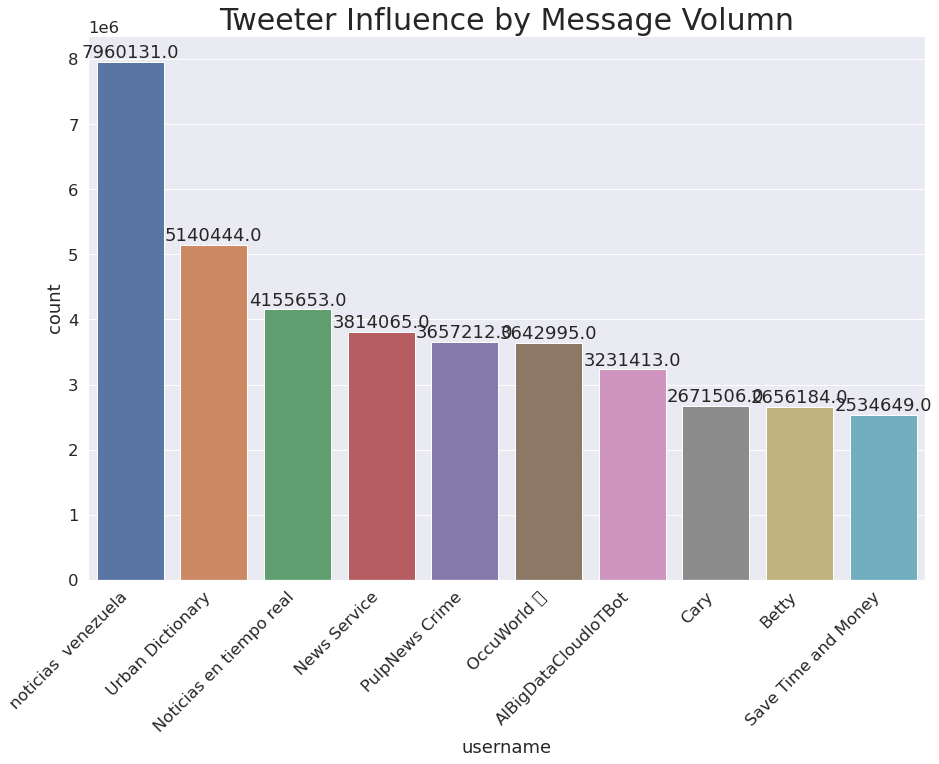

In [22]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale=1.5)
ax = sns.barplot(x="username", y="count", data=message1)
ax.set_title('Tweeter Influence by Message Volumn',fontsize=30)
ax.set_xticklabels(ax.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right')
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 


### 2) By message retweet
* I chose to use retweet_count, tweeters have the most reweet counts means tehy have more influencial power than others.

In [14]:
retweet=pd.DataFrame(dff.groupby('userid')['retweet_count'].max()).reset_index()
retweet1=retweet.sort_values(by = ['retweet_count'], ascending=False)[0:10]

In [15]:
id2=[i for i in retweet1.userid]
name2=[]
for i in id2:
    name2.append(dff.loc[dff['userid'] == i, 'username'].iloc[0])
print(name2)

['Portiallie X', 'ann', 'ella', 'Charlotte Nicholson', 'Pak Man', 'BADLIAR', 'Amaia', 'Kalli Ruffennach', 'Maddi_Yo', 'Cassandra']


In [16]:
retweet1.insert(loc=1, column='username', value=name2)

In [17]:
retweet1

userid             username  retweet_count
349514  3.283947e+09         Portiallie X        26638.0
419690  8.096531e+17                  ann        26637.0
275385  2.185228e+09                 ella        26625.0
447822  8.797889e+17  Charlotte Nicholson        26624.0
289053  2.359881e+09              Pak Man        26610.0
97280   1.294070e+08              BADLIAR        26608.0
345488  3.227708e+09                Amaia        26558.0
330859  2.983398e+09     Kalli Ruffennach        26555.0
421771  8.160484e+17             Maddi_Yo        26549.0
435134  8.436678e+17            Cassandra        26547.0

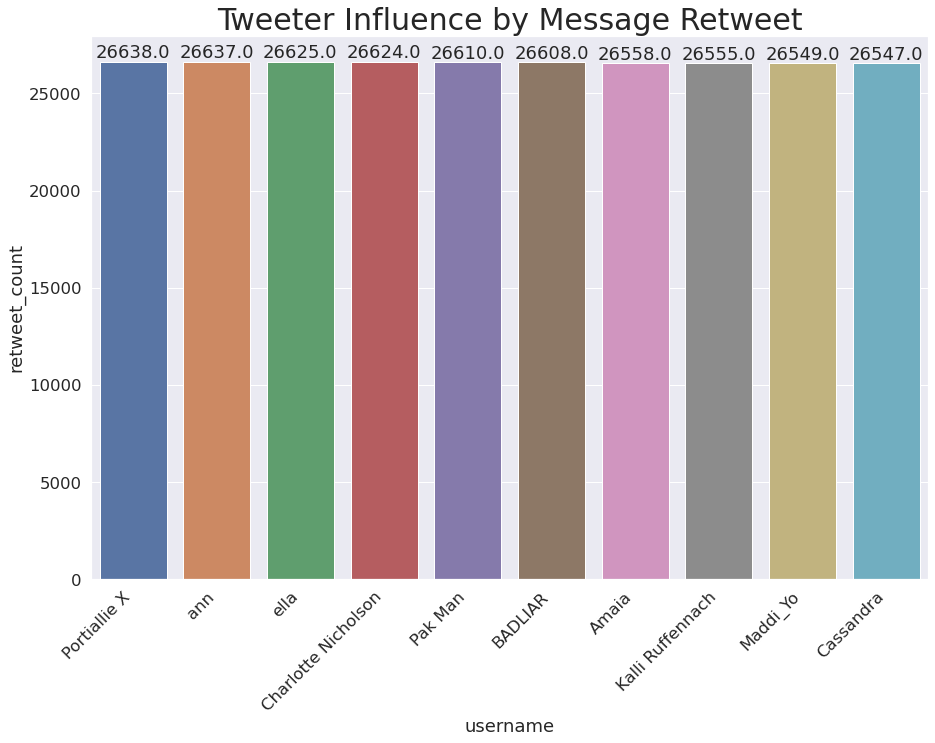

In [27]:
#sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale = 1.5)
g = sns.barplot(x="username", y="retweet_count", data=retweet1)
g.set_title('Tweeter Influence by Message Retweet', fontsize=30)
g.set_xticklabels(g.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right')
for p in g.patches:
       g.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### 3) How much are they tweeting about the Universities vs. other topics?
* All the tweets in the dff dataset are the four universities related data, so I will count how many tweets those top tweeters have in the dff dataset and use the user's statues_count (which is the total tweetes the tweeter has tweeted in history) minus the count frequency. This should give me the Universities vs other topics result. 

In [18]:
#combine the 20 tweeters from the previous analysis
userid1=message1.userid.tolist() + retweet1.userid.tolist()
username1=message1.username.tolist() + retweet1.username.tolist()


In [19]:
print([i for i in retweet1.userid])

[3283946605.0, 8.096531080327045e+17, 2185228296.0, 8.797889133799465e+17, 2359880569.0, 129406956.0, 3227707802.0, 2983398274.0, 8.160484414323589e+17, 8.436678342155508e+17]


In [20]:
# filter the 20 tweeters' data
uni_data= dff[dff.userid.isin(userid1)]
uni_data.head(5)

userid     username userlocation verified  userfollowers_count  \
40475  1.179711e+09  OccuWorld 🏴        Earth    False               8362.0   
53177  1.349720e+08        Betty     Colorado    False              10134.0   
56110  1.179711e+09  OccuWorld 🏴        Earth    False               8417.0   
68402  1.179711e+09  OccuWorld 🏴        Earth    False               8356.0   
95869  1.349720e+08        Betty     Colorado    False               9746.0   

       userfriends_count  userlisted_count  userfavor_count  userstat_count  \
40475             1680.0            1181.0          29875.0       3506013.0   
53177            10232.0             519.0             53.0       2578339.0   
56110             1718.0            1132.0          32978.0       3550034.0   
68402             1673.0            1181.0          29754.0       3502864.0   
95869             9650.0             554.0            815.0       2287624.0   

                           created_at  ... place_fullname statuses_count  \
40475  Fri May 01 22:21:00 +0000 2020  ...            NaN         3523.0   
53177  Tue Jun 16 14:40:33 +0000 2020  ...            NaN       267580.0   
56110  Sat Jun 27 02:57:46 +0000 2020  ...            NaN            NaN   
68402  Mon Apr 27 21:32:28 +0000 2020  ...            NaN            NaN   
95869  Tue Aug 06 17:28:08 +0000 2019  ...            NaN        56185.0   

      retweet_count  favorite_count  reply_count  quote_count  \
40475          41.0            90.0          0.0          2.0   
53177         173.0           417.0         81.0         80.0   
56110           NaN             NaN          NaN          NaN   
68402           NaN             NaN          NaN          NaN   
95869          61.0           174.0         20.0         10.0   

       text_quote_count  filter_level  \
40475               0.0           low   
53177               0.0           low   
56110               0.0           low   
68402               0.0           low   
95869               0.0           low   

                                                 fulltxt  \
40475                                                NaN   
53177                                                NaN   
56110                                                NaN   
68402  Talk: “The Problem of Newness: Art Cinema in I...   
95869                                                NaN   

                                                    text  
40475  RT @MHendricksonCST: Hundreds refuse to pay UC...  
53177  RT @AP: Spoiler alert: 2020 has been rough on ...  
56110  University of Chicago students stage sit-in to...  
68402  Talk: “The Problem of Newness: Art Cinema in I...  
95869  RT @crampell: Kudlow needs this reading list t...  

[5 rows x 22 columns]

In [21]:
count=pd.DataFrame(uni_data.userid.value_counts()).reset_index()
count.columns=['userid','count']
count

userid  count
0   1.179711e+09     37
1   1.349720e+08     23
2   1.009870e+08     17
3   1.416273e+08      5
4   2.319610e+09      5
5   2.791183e+08      3
6   5.950272e+06      3
7   6.529402e+06      2
8   2.846486e+09      2
9   8.160484e+17      1
10  2.983398e+09      1
11  3.227708e+09      1
12  8.797889e+17      1
13  3.283947e+09      1
14  1.551800e+07      1
15  8.436678e+17      1
16  2.359881e+09      1
17  1.294070e+08      1
18  8.096531e+17      1
19  2.185228e+09      1

In [22]:

vis1=pd.DataFrame(uni_data.groupby('userid')['userstat_count'].max()).reset_index()

In [23]:
vis2=pd.merge(vis1,count, on="userid")
vis2

userid  userstat_count  count
0   5.950272e+06       2671506.0      3
1   6.529402e+06       7960131.0      2
2   1.551800e+07       5140444.0      1
3   1.009870e+08       3657212.0     17
4   1.294070e+08         83246.0      1
5   1.349720e+08       2656184.0     23
6   1.416273e+08       4155653.0      5
7   2.791183e+08       3814065.0      3
8   1.179711e+09       3642995.0     37
9   2.185228e+09         31967.0      1
10  2.319610e+09       3231413.0      5
11  2.359881e+09         42503.0      1
12  2.846486e+09       2534649.0      2
13  2.983398e+09           403.0      1
14  3.227708e+09           125.0      1
15  3.283947e+09          4434.0      1
16  8.096531e+17          3392.0      1
17  8.160484e+17          1738.0      1
18  8.436678e+17           262.0      1
19  8.797889e+17           573.0      1

In [24]:
vis2['other_topics']=vis2['userstat_count']-vis2['count']
vis2['university']=(vis2['count']/vis2['userstat_count'])*100
vis2['others']=(vis2['other_topics']/vis2['userstat_count'])*100
vis2

userid  userstat_count  count  other_topics  university     others
0   5.950272e+06       2671506.0      3     2671503.0    0.000112  99.999888
1   6.529402e+06       7960131.0      2     7960129.0    0.000025  99.999975
2   1.551800e+07       5140444.0      1     5140443.0    0.000019  99.999981
3   1.009870e+08       3657212.0     17     3657195.0    0.000465  99.999535
4   1.294070e+08         83246.0      1       83245.0    0.001201  99.998799
5   1.349720e+08       2656184.0     23     2656161.0    0.000866  99.999134
6   1.416273e+08       4155653.0      5     4155648.0    0.000120  99.999880
7   2.791183e+08       3814065.0      3     3814062.0    0.000079  99.999921
8   1.179711e+09       3642995.0     37     3642958.0    0.001016  99.998984
9   2.185228e+09         31967.0      1       31966.0    0.003128  99.996872
10  2.319610e+09       3231413.0      5     3231408.0    0.000155  99.999845
11  2.359881e+09         42503.0      1       42502.0    0.002353  99.997647
12  2.846486e+09       2534649.0      2     2534647.0    0.000079  99.999921
13  2.983398e+09           403.0      1         402.0    0.248139  99.751861
14  3.227708e+09           125.0      1         124.0    0.800000  99.200000
15  3.283947e+09          4434.0      1        4433.0    0.022553  99.977447
16  8.096531e+17          3392.0      1        3391.0    0.029481  99.970519
17  8.160484e+17          1738.0      1        1737.0    0.057537  99.942463
18  8.436678e+17           262.0      1         261.0    0.381679  99.618321
19  8.797889e+17           573.0      1         572.0    0.174520  99.825480

In [25]:
np.mean(vis2.university)

0.08617640406357277

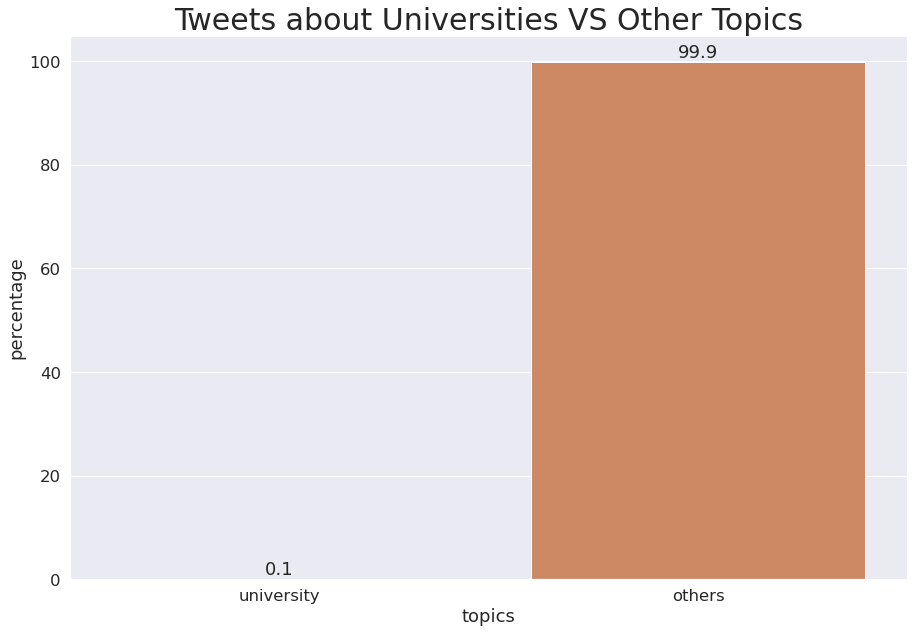

In [26]:
avg=pd.DataFrame({'topics': ['university','others'], 'percentage': [np.mean(vis2.university), np.mean(vis2.others)]})
sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale = 1.5)
g = sns.barplot(x="topics", y="percentage", data=avg)
g.set_title('Tweets about Universities VS Other Topics', fontsize=30)
for p in g.patches:
       g.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

# 2. Where are these Twitterers located?
### 1) For UChicago

In [33]:
df2=dff_uchi[dff_uchi['userid'].isin(userid1)][['userid','username','userlocation','text']]

In [34]:
df2_loc=pd.DataFrame(dff_uchi.userlocation.value_counts()).reset_index()
df2_loc.columns=['userlocation','count']

In [35]:
df2_loc[0:10]

userlocation  count
0         Chicago, IL  60349
1             Chicago  18736
2       United States   9267
3   Chicago, Illinois   9185
4      Washington, DC   5735
5        New York, NY   4626
6                 USA   4174
7   Chicago, IL 60637   3260
8     Los Angeles, CA   3127
9  Hyde Park, Chicago   2682

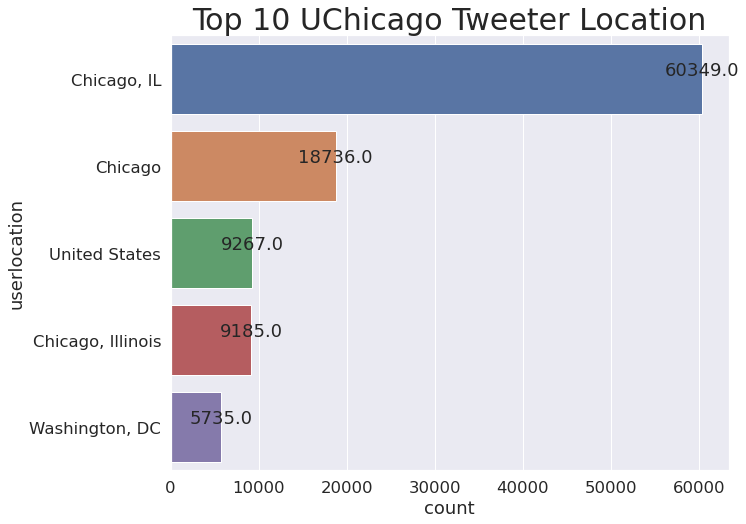

In [36]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale = 1.5)
ax = sns.barplot(y="userlocation", x="count", data=df2_loc[0:5])
ax.set_title('Top 10 UChicago Tweeter Location',fontsize=30)

for p in ax.patches:
       ax.annotate(format(p.get_width(), '.1f'), 
                   (p.get_width(), p.get_y() + p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### 2) For University of Nebraska

In [37]:
df3_loc=pd.DataFrame(dff_unl.userlocation.value_counts()).reset_index()
df3_loc.columns=['userlocation','count']

In [38]:
df3_loc[0:10]

userlocation  count
0          Omaha, NE  12521
1        Lincoln, NE  10343
2      Nebraska, USA   6939
3      United States   2796
4           Nebraska   2782
5           Omaha,NE   1298
6  Lincoln, Nebraska   1208
7       Beatrice, NE   1206
8    Omaha, Nebraska   1143
9         Lincoln,NE   1093

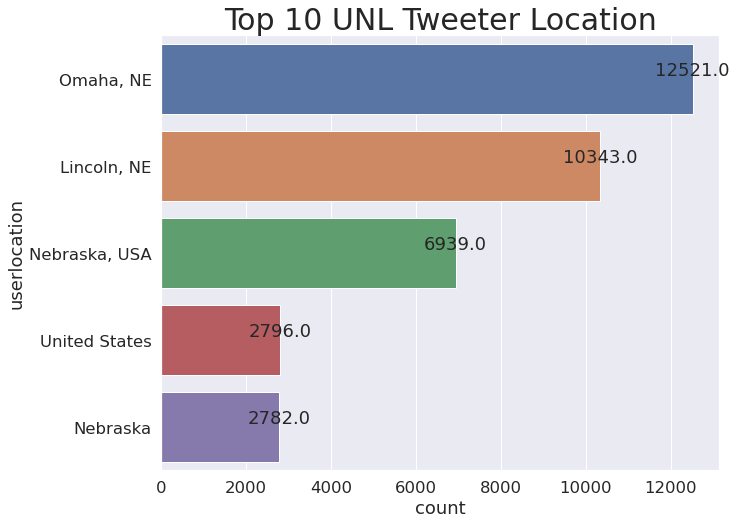

In [39]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale = 1.5)
ax = sns.barplot(y="userlocation", x="count", data=df3_loc[0:5])
ax.set_title('Top 10 UNL Tweeter Location',fontsize=30)

for p in ax.patches:
       ax.annotate(format(p.get_width(), '.1f'), 
                   (p.get_width(), p.get_y() + p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### 3) For Northeast University

In [40]:
df4_loc=pd.DataFrame(dff_north.userlocation.value_counts()).reset_index()
df4_loc.columns=['userlocation','count']

In [41]:
df4_loc[0:10]

userlocation  count
0          Boston, MA  14788
1       United States   2985
2              Boston    950
3                 USA    515
4  Massachusetts, USA    513
5      Washington, DC    484
6        New York, NY    455
7     California, USA    432
8     Los Angeles, CA    377
9         Chicago, IL    356

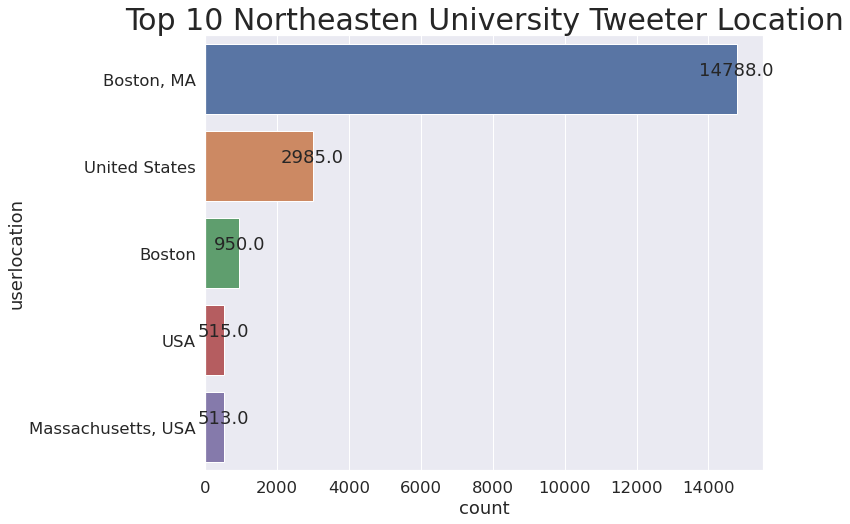

In [42]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale = 1.5)
ax = sns.barplot(y="userlocation", x="count", data=df4_loc[0:5])
ax.set_title('Top 10 Northeasten University Tweeter Location', fontsize=30)

for p in ax.patches:
       ax.annotate(format(p.get_width(), '.1f'), 
                   (p.get_width(), p.get_y() + p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### 4) For Brown University

In [43]:
df5_loc=pd.DataFrame(dff_brown.userlocation.value_counts()).reset_index()
df5_loc.columns=['userlocation','count']

In [44]:
df5_loc[0:10]

userlocation  count
0            Providence, RI  12243
1             United States   4575
2                       USA   1739
3                Boston, MA   1227
4            Washington, DC   1202
5           California, USA   1159
6              New York, NY   1123
7  Providence, Rhode Island   1050
8              Rhode Island   1022
9                Texas, USA   1008

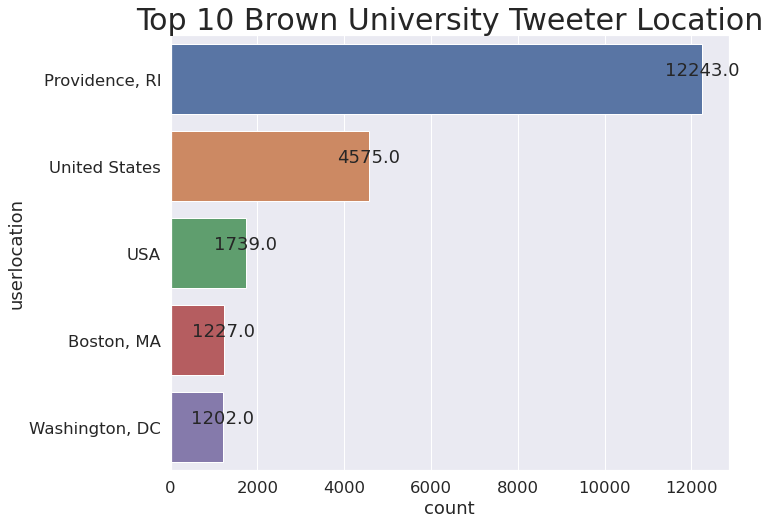

In [45]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale = 1.5)
ax = sns.barplot(y="userlocation", x="count", data=df5_loc[0:5])
ax.set_title('Top 10 Brown University Tweeter Location', fontsize=30)

for p in ax.patches:
       ax.annotate(format(p.get_width(), '.1f'), 
                   (p.get_width(), p.get_y() + p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### 5) Do you see any relationship between university locations and Twitterers’ locations?

Yes, all top tweeters for Northeast University and UNL locate in the same city as the university is at. For Uchicago and Brown, most tweeters locate at the university's location, but there are also a lot tweeters from Washington DC and Boston.

# 3. What distinguishes University of Chicago Twitterers vs Twitterers who tweet about other universities
### I chose to compare user's follower_count, favorate_count, reply_count and firends_count to distinguish University of Chicago Twitterers vs Twitterers

### 1) User's follower_count
* Considering the data is dynamic and same user 

In [12]:
dff_uchi_foll=dff_uchi[['userid','userfollowers_count']]
dff_uchi_foll=dff_uchi_foll.groupby(['userid'])['userfollowers_count'].max().dropna().reset_index()
#dff_uchi_foll['userfollowers_count']=dff_uchi_foll['userfollowers_count'].astype(int)



In [ ]:
plt.hist(dff_uchi_foll.userfollowers_count, bins='auto')

In [13]:
dff_unl_foll=dff_unl[['userid','userfollowers_count']]
dff_unl_foll=dff_unl_foll.groupby(['userid'])['userfollowers_count'].max().reset_index()

dff_north_foll=dff_north[['userid','userfollowers_count']]
dff_north_foll=dff_north_foll.groupby(['userid'])['userfollowers_count'].max().reset_index()

dff_brown_foll=dff_brown[['userid','userfollowers_count']]
dff_brown_foll=dff_brown_foll.groupby(['userid'])['userfollowers_count'].max().reset_index()

In [27]:
avg_foll=pd.DataFrame()
avg_foll['University']=['UChicago','UNL','Northeastern','Brown']
avg_foll['Average_Followers']=[dff_uchi_foll['userfollowers_count'].mean(),dff_unl_foll['userfollowers_count'].mean(),
                               dff_north_foll['userfollowers_count'].mean(),dff_brown_foll['userfollowers_count'].mean()]
avg_foll

University  Average_Followers
0      UChicago        4952.846994
1           UNL        3924.102837
2  Northeastern        8860.272167
3         Brown        6150.747682

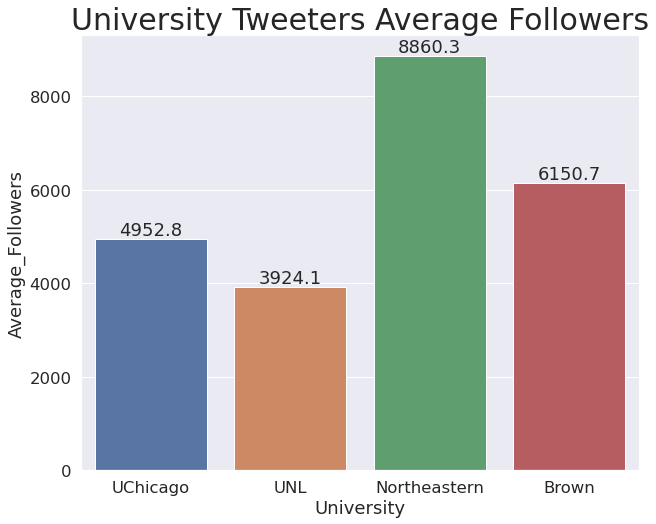

In [28]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale = 1.5)
ax = sns.barplot(x="University", y="Average_Followers", data=avg_foll)
ax.set_title('University Tweeters Average Followers',fontsize=30)

for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 


### 2) User favorate_count
* Same as the follower_count, I will group by userid first and return the max favorate_count form each user

In [17]:
dff_uchi_fav=dff_uchi[['userid','userfavor_count']]
dff_uchi_fav=dff_uchi_fav.groupby(['userid'])['userfavor_count'].max().reset_index()

dff_unl_fav=dff_unl[['userid','userfavor_count']]
dff_unl_fav=dff_unl_fav.groupby(['userid'])['userfavor_count'].max().reset_index()

dff_north_fav=dff_north[['userid','userfavor_count']]
dff_north_fav=dff_north_fav.groupby(['userid'])['userfavor_count'].max().reset_index()

dff_brown_fav=dff_brown[['userid','userfavor_count']]
dff_brown_fav=dff_brown_fav.groupby(['userid'])['userfavor_count'].max().reset_index()

In [29]:
avg_fav=pd.DataFrame()
avg_fav['University']=['UChicago','UNL','Northeastern','Brown']
avg_fav['Average_Favorate']=[dff_uchi_fav['userfavor_count'].mean(),dff_unl_fav['userfavor_count'].mean(),
                               dff_north_fav['userfavor_count'].mean(),dff_brown_fav['userfavor_count'].mean()]
avg_fav

University  Average_Favorate
0      UChicago      23308.809580
1           UNL      14517.271753
2  Northeastern      29204.165251
3         Brown      27960.150924

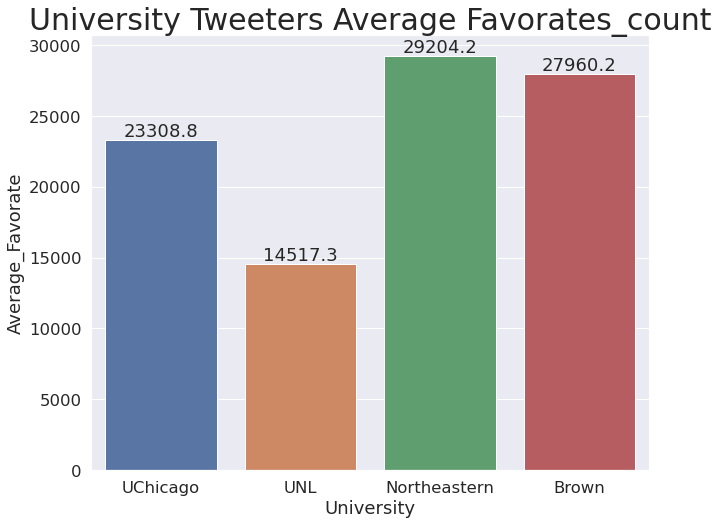

In [30]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale = 1.5)
ax = sns.barplot(x="University", y="Average_Favorate", data=avg_fav)
ax.set_title('University Tweeters Average Favorates_count',fontsize=30)

for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### 3)Users listed_count
* listed_count: number of times of being listed/ The number of public lists that this user is a member of.

In [21]:
dff_uchi_list=dff_uchi[['userid','userlisted_count']]
dff_uchi_list=dff_uchi_list.groupby(['userid'])['userlisted_count'].max().reset_index()

dff_unl_list=dff_unl[['userid','userlisted_count']]
dff_unl_list=dff_unl_list.groupby(['userid'])['userlisted_count'].max().reset_index()

dff_north_list=dff_north[['userid','userlisted_count']]
dff_north_list=dff_north_list.groupby(['userid'])['userlisted_count'].max().reset_index()

dff_brown_list=dff_brown[['userid','userlisted_count']]
dff_brown_list=dff_brown_list.groupby(['userid'])['userlisted_count'].max().reset_index()

In [31]:
avg_list=pd.DataFrame()
avg_list['University']=['UChicago','UNL','Northeastern','Brown']
avg_list['Average_Listed_Count']=[dff_uchi_list['userlisted_count'].mean(),dff_unl_list['userlisted_count'].mean(),
                               dff_north_list['userlisted_count'].mean(),dff_brown_list['userlisted_count'].mean()]
avg_list

University  Average_Listed_Count
0      UChicago             64.874718
1           UNL             42.088959
2  Northeastern             85.367519
3         Brown             66.749579

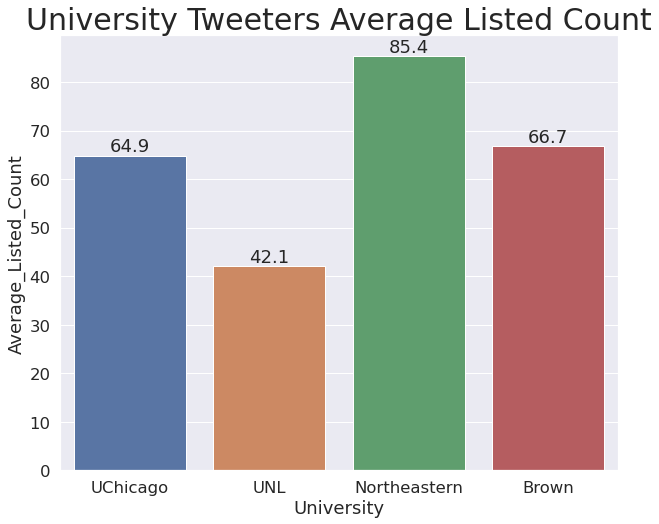

In [32]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale = 1.5)
ax = sns.barplot(x="University", y="Average_Listed_Count", data=avg_list)
ax.set_title('University Tweeters Average Listed Count',fontsize=30)

for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### 4) Users' Friends_Count

In [24]:
dff_uchi_friend=dff_uchi[['userid','userfriends_count']]
dff_uchi_friend=dff_uchi_friend.groupby(['userid'])['userfriends_count'].max().reset_index()

dff_unl_friend=dff_unl[['userid','userfriends_count']]
dff_unl_friend=dff_unl_friend.groupby(['userid'])['userfriends_count'].max().reset_index()

dff_north_friend=dff_north[['userid','userfriends_count']]
dff_north_friend=dff_north_friend.groupby(['userid'])['userfriends_count'].max().reset_index()

dff_brown_friend=dff_brown[['userid','userfriends_count']]
dff_brown_friend=dff_brown_friend.groupby(['userid'])['userfriends_count'].max().reset_index()

In [33]:
avg_friend=pd.DataFrame()
avg_friend['University']=['UChicago','UNL','Northeastern','Brown']
avg_friend['Average_Friend']=[dff_uchi_friend['userfriends_count'].mean(),dff_unl_friend['userfriends_count'].mean(),
                               dff_north_friend['userfriends_count'].mean(),dff_brown_friend['userfriends_count'].mean()]
avg_friend

University  Average_Friend
0      UChicago     1439.948028
1           UNL     1165.936805
2  Northeastern     1784.255978
3         Brown     1741.088774

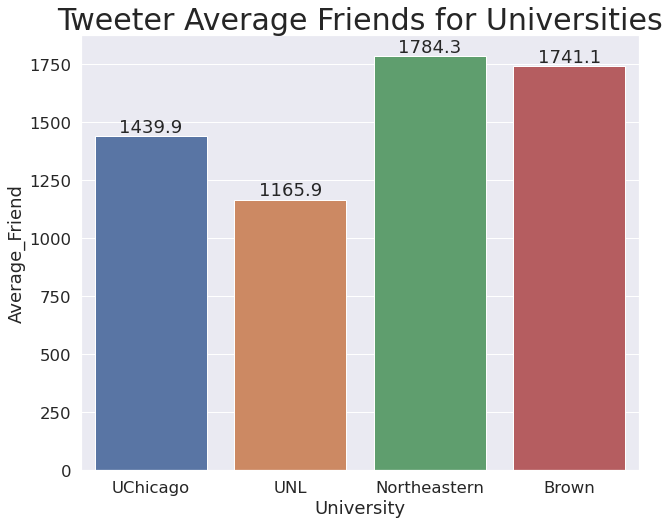

In [34]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale = 1.5)
ax = sns.barplot(x="University", y="Average_Friend", data=avg_friend)
ax.set_title('Tweeter Average Friends for Universities',fontsize=30)

for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

## Summary:
Both Northeast's and Brown's tweeters have higher average follower_counts, favorate_counts, listed-counts and friend's count. This means Northeastern and Brown Tweeters are more active on tweeter than UNL and Uchicago's tweeters.

# 4. What are the timelines of these tweets? Do you see significant peaks and valleys?
Do you see data collection gaps?

In [35]:
t=pd.to_datetime(dff['created_at'])

In [36]:
time=pd.DataFrame(t)
time.head(5)

created_at
0 2017-06-22 23:28:13+00:00
1 2017-06-22 23:33:37+00:00
2 2017-06-22 23:35:29+00:00
3 2017-06-22 23:36:01+00:00
4 2017-06-22 23:42:33+00:00

In [103]:
dff_d=time.resample('D', on='created_at').count()
dff_d.columns=['Count']
#dff_d.reset_index()

In [104]:
dff_y=time.resample('Y', on='created_at').count()
dff_y.columns=['Count']

In [100]:
# gaps occured in these periods
[str(i.date()) for i in dff_d[dff_d.created_at==0].index]

['2018-01-06',
 '2018-01-07',
 '2018-01-08',
 '2018-01-09',
 '2018-01-10',
 '2018-01-11',
 '2018-01-12',
 '2018-01-13',
 '2018-01-14',
 '2018-01-15',
 '2018-01-16',
 '2018-01-17',
 '2018-01-18',
 '2018-01-19',
 '2018-01-20',
 '2018-01-21',
 '2018-01-22',
 '2018-01-23',
 '2018-01-24',
 '2018-01-25',
 '2018-01-26',
 '2018-01-27',
 '2018-01-28',
 '2018-01-29',
 '2018-01-30',
 '2018-01-31',
 '2018-02-01',
 '2018-02-02',
 '2018-02-03',
 '2018-02-04',
 '2018-02-05',
 '2018-02-06',
 '2018-02-07',
 '2018-02-08',
 '2018-02-09',
 '2018-02-10',
 '2018-02-11',
 '2018-02-12',
 '2018-04-03',
 '2018-04-04',
 '2018-04-05',
 '2018-04-06',
 '2018-04-07',
 '2018-04-08',
 '2018-04-09',
 '2018-04-10',
 '2018-04-11',
 '2018-04-12',
 '2018-04-13',
 '2018-04-14',
 '2018-04-15',
 '2018-04-16',
 '2018-04-17',
 '2018-04-18',
 '2018-04-19',
 '2018-04-20',
 '2018-04-21']

Text(0.5, 1.0, 'Total Tweets by Date')

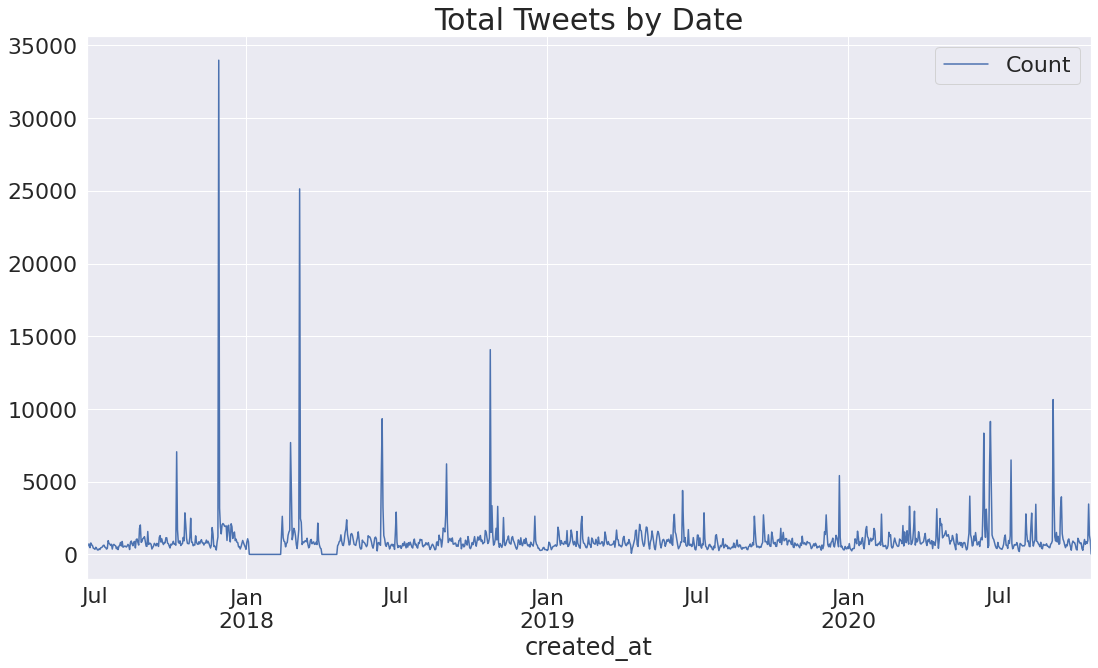

In [105]:
#plotly.offline.init_notebook_modget_level_valuesed=True)
sns.set(rc={'figure.figsize':(18,10)})
sns.set(font_scale = 2)
ax=dff_d.plot()
ax.set_title('Total Tweets by Date', fontsize=30)

Text(0.5, 1.0, 'Total Tweets by Year')

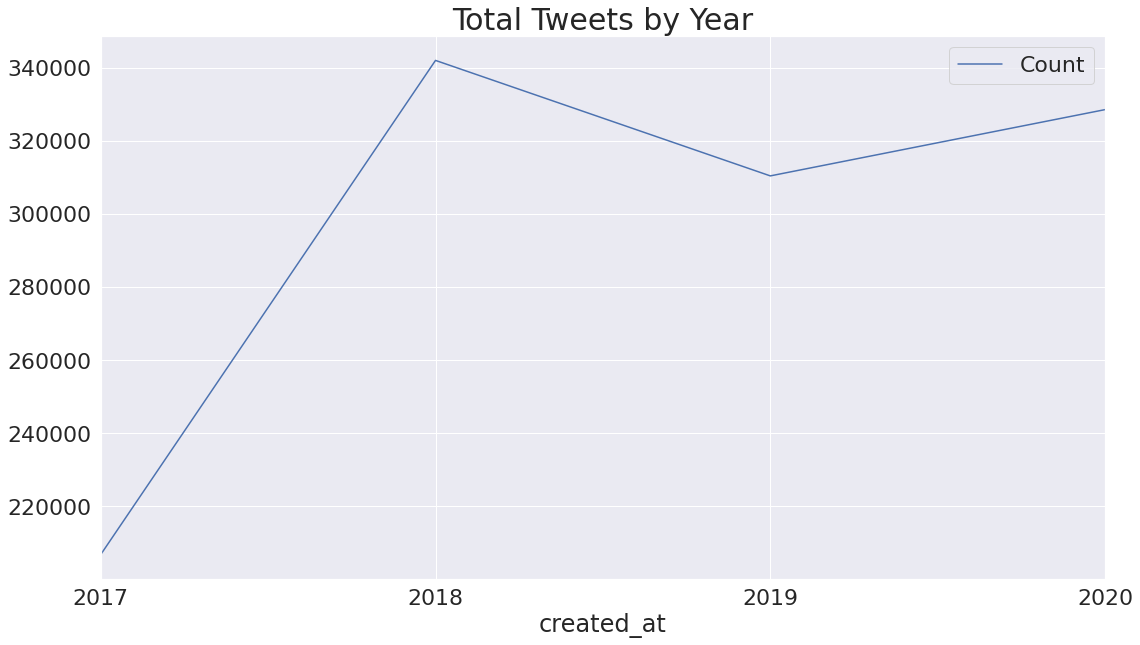

In [106]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set(font_scale = 2)
ax=dff_y.plot()
ax.set_title('Total Tweets by Year', fontsize=30)

In [108]:
dff_d1=dff_d.reset_index()
dff_d1

created_at  Count
0    2017-06-22 00:00:00+00:00    530
1    2017-06-23 00:00:00+00:00    516
2    2017-06-24 00:00:00+00:00    703
3    2017-06-25 00:00:00+00:00    709
4    2017-06-26 00:00:00+00:00    461
...                        ...    ...
1213 2020-10-17 00:00:00+00:00    936
1214 2020-10-18 00:00:00+00:00   3462
1215 2020-10-19 00:00:00+00:00   1310
1216 2020-10-20 00:00:00+00:00    963
1217 2020-10-21 00:00:00+00:00     22

[1218 rows x 2 columns]

In [109]:
dff_d1['gap']=(dff_d1.created_at.diff())

In [116]:
dff_d1[dff_d1.gap!='1 day']

created_at  Count gap
0 2017-06-22 00:00:00+00:00    530 NaT

## Summary:
The tweets data is collected from 2017/06/22 - 2020/10/21.
There are several big peaks, including 2017/11/29,   2018/03/07,   2018/06/15, 2018/10/24, 2020/06/21,  202/09/05.
There are two big gaps: 2018/01/01 - 2018/02/12, 2018/04/03 - 2018/04/21.
Overall, there are 2 big peaks in 2017, 5 big peaks in 2018, 2 big peaks in 2019, and 4 big peaks in 2020. Moreover, there is an increasing amount in tweets from 2017 to 2018, a decrease from 2018 to 2019, and a recap from 2019 to 2020. 



# 5. How unique are the messages for each of these universities?
Are they mostly unique? Or mostly people are just copy-pasting the same text?


In [7]:
def get_features(s):
    width = 3
    s = s.lower()
    s = re.sub(r'[^\w]+', '', s)
    return [s[i:i + width] for i in range(np.maximum(len(s) - width + 1, 1))]

In [8]:
def dup(df,K):
    #dic=dict(map(lambda t: (t[0], t[1]), enumerate(df.tolist())))
    objs = [(str(k), Simhash(get_features(v))) for k, v in df.items()]
    index = SimhashIndex(objs, k=K)
    track={}
    for doc in objs:
        dupe=index.get_near_dups(doc[1])
        if len(dupe) == 1:
           
            track[doc[0]] = [len(dupe), 0]
        else:
            
             track[doc[0]] = [len(dupe), 1]
    return track

In [14]:
## since uchicago dataset is very large and has more data than the other three universities, i will take 100,000 smaples from the uchicago dataset
sample_uchi=pd.DataFrame(dff_uchi.text.sample(n=100000))
sample_uchi['text']=sample_uchi.text.astype('str')

In [ ]:
uc=dup(sample_uchi.text, 3)

Big bucket found. key:c228:0, len:4963
Big bucket found. key:88d2:1, len:4963
Big bucket found. key:8e4c:2, len:4964
Big bucket found. key:a5f0:3, len:4964
Big bucket found. key:c228:0, len:4963
Big bucket found. key:88d2:1, len:4963
Big bucket found. key:8e4c:2, len:4964
Big bucket found. key:a5f0:3, len:4964
Big bucket found. key:672:0, len:750
Big bucket found. key:fbc7:1, len:750
Big bucket found. key:c4b7:2, len:751
Big bucket found. key:b8f6:3, len:750
Big bucket found. key:8313:0, len:424
Big bucket found. key:4104:1, len:464
Big bucket found. key:c97e:2, len:418
Big bucket found. key:e85:3, len:418
Big bucket found. key:41c4:1, len:201
Big bucket found. key:c228:0, len:4963
Big bucket found. key:88d2:1, len:4963
Big bucket found. key:8e4c:2, len:4964
Big bucket found. key:a5f0:3, len:4964
Big bucket found. key:dbb1:0, len:4764
Big bucket found. key:40e0:1, len:4765
Big bucket found. key:8cf5:2, len:4767
Big bucket found. key:4cfd:3, len:4766
Big bucket found. key:c755:0, len:44

In [ ]:
df_t1=pd.DataFrame.from_dict(uc, orient='index',columns=['count', 'dupe'])
df_t1.head(10)

count  dupe
496340      1     0
174865      1     0
40702       1     0
132097      2     1
634645      7     1
563612      1     0
51130      14     1
335426   4963     1
635386      7     1
182391     14     1

In [ ]:
df_t1['dupe'].value_counts()

1    57914
0    42086
Name: dupe, dtype: int64

<AxesSubplot:>

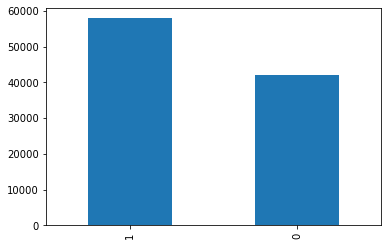

In [ ]:
df_t1['dupe'].value_counts().plot(kind = 'bar', fontsize=10)
plt.ylabel('Count of Documents', labelpad =5.0)
plt.xlabel('Document Type', labelpad =5.0)
plt.title('Count of Unique Documents vs Duplicated Documents', pad = 20.0)
positions = (0,1)
labels = ("Unique", "Duplicated")
plt.xticks(positions, labels, rotation = 25)
plt.show()

### For UNL

In [12]:
## take 50,000 sample from unl dataset
sample_unl=pd.DataFrame(dff_unl.sample(n=50000))
unl=dup(sample_unl.text, 3)

Big bucket found. key:2a19:0, len:244
Big bucket found. key:f103:1, len:238
Big bucket found. key:28c5:2, len:238
Big bucket found. key:754d:3, len:239
Big bucket found. key:d6a:2, len:572
Big bucket found. key:d4a:2, len:520
Big bucket found. key:56a:2, len:348
Big bucket found. key:4ddb:2, len:214
Big bucket found. key:9c9f:0, len:301
Big bucket found. key:7aec:1, len:300
Big bucket found. key:e1bb:2, len:300
Big bucket found. key:1858:3, len:300
Big bucket found. key:d6a:2, len:572
Big bucket found. key:56a:2, len:348
Big bucket found. key:56a:2, len:348
Big bucket found. key:d68:2, len:203
Big bucket found. key:96a:2, len:361
Big bucket found. key:5019:0, len:404
Big bucket found. key:4424:1, len:407
Big bucket found. key:94cc:2, len:404
Big bucket found. key:2909:3, len:404
Big bucket found. key:8d6a:2, len:502
Big bucket found. key:45b7:0, len:697
Big bucket found. key:c648:1, len:725
Big bucket found. key:752:2, len:697
Big bucket found. key:7b61:3, len:697
Big bucket found. key

In [13]:
df_t2=pd.DataFrame.from_dict(unl, orient='index',columns=['count', 'dupe'])
df_t2.head(10)

count  dupe
22583      77     1
77648      23     1
71692       1     0
104079      1     0
57584      15     1
132903    238     1
87943      12     1
89603      34     1
50698       1     0
2225       48     1

In [14]:
df_t2['dupe'].value_counts()

1    39834
0    10166
Name: dupe, dtype: int64

<AxesSubplot:>

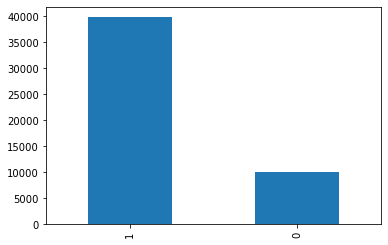

In [15]:
df_t2['dupe'].value_counts().plot(kind = 'bar', fontsize=10)

### For Northeastern

In [9]:
#take sampel for northeastern
sample_north=pd.DataFrame(dff_north.sample(n=20000))
north=sample_north.text.astype('str')
northeast=dup(north, 3)

Big bucket found. key:c228:0, len:11441
Big bucket found. key:88d2:1, len:11441
Big bucket found. key:8e4c:2, len:11441
Big bucket found. key:a5f0:3, len:11441
Big bucket found. key:c228:0, len:11441
Big bucket found. key:88d2:1, len:11441
Big bucket found. key:8e4c:2, len:11441
Big bucket found. key:a5f0:3, len:11441
Big bucket found. key:c228:0, len:11441
Big bucket found. key:88d2:1, len:11441
Big bucket found. key:8e4c:2, len:11441
Big bucket found. key:a5f0:3, len:11441
Big bucket found. key:c228:0, len:11441
Big bucket found. key:88d2:1, len:11441
Big bucket found. key:8e4c:2, len:11441
Big bucket found. key:a5f0:3, len:11441
Big bucket found. key:c228:0, len:11441
Big bucket found. key:88d2:1, len:11441
Big bucket found. key:8e4c:2, len:11441
Big bucket found. key:a5f0:3, len:11441
Big bucket found. key:c228:0, len:11441
Big bucket found. key:88d2:1, len:11441
Big bucket found. key:8e4c:2, len:11441
Big bucket found. key:a5f0:3, len:11441
Big bucket found. key:c228:0, len:11441


In [10]:
df_t3=pd.DataFrame.from_dict(northeast, orient='index',columns=['count', 'dupe'])
df_t3.head(10)

count  dupe
206404      1     0
147827  11441     1
207958     84     1
162159  11441     1
17194       1     0
81101   11441     1
78905   11441     1
152621  11441     1
100954  11441     1
127064  11441     1

In [11]:
df_t3['dupe'].value_counts()

1    16550
0     3450
Name: dupe, dtype: int64

<AxesSubplot:>

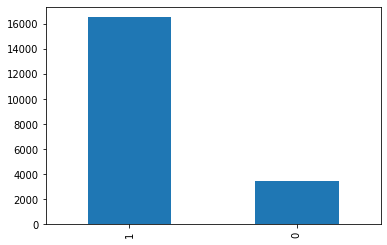

In [12]:
df_t3['dupe'].value_counts().plot(kind = 'bar', fontsize=10)

### For Brown

In [15]:
#take 30,000 sample
sample_brown=pd.DataFrame(dff_brown.sample(n=30000))
sample=sample_brown.text.astype('str')
brown=dup(sample, 3)

Big bucket found. key:150a:0, len:238
Big bucket found. key:2686:1, len:236
Big bucket found. key:6d68:2, len:245
Big bucket found. key:905:3, len:247
Big bucket found. key:c228:0, len:3649
Big bucket found. key:88d2:1, len:3649
Big bucket found. key:8e4c:2, len:3649
Big bucket found. key:a5f0:3, len:3649
Big bucket found. key:b50d:0, len:851
Big bucket found. key:b47:1, len:848
Big bucket found. key:afc5:2, len:848
Big bucket found. key:a8c5:3, len:848
Big bucket found. key:b50d:0, len:851
Big bucket found. key:b47:1, len:848
Big bucket found. key:afc5:2, len:848
Big bucket found. key:a8c5:3, len:848
Big bucket found. key:2c1a:0, len:1016
Big bucket found. key:7dfd:1, len:1014
Big bucket found. key:a568:2, len:1014
Big bucket found. key:6a24:3, len:1019
Big bucket found. key:2c1a:0, len:1016
Big bucket found. key:7dfd:1, len:1014
Big bucket found. key:a568:2, len:1014
Big bucket found. key:6a24:3, len:1019
Big bucket found. key:1f99:0, len:658
Big bucket found. key:950a:1, len:660
Big

In [16]:
df_t4=pd.DataFrame.from_dict(brown, orient='index',columns=['count', 'dupe'])
df_t4.head(10)

count  dupe
54633      75     1
128197      1     0
152114    236     1
41783      65     1
181907     63     1
116982     25     1
258167   3649     1
30951     848     1
105041     44     1
77904       1     0

In [17]:
df_t4['dupe'].value_counts()

1    19277
0    10723
Name: dupe, dtype: int64

<AxesSubplot:>

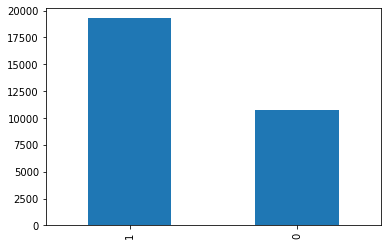

In [18]:
df_t4['dupe'].value_counts().plot(kind = 'bar', fontsize=10)

## Summary: 
Uchicago has 42.1% unique and 57.9% near_duplicates tweets; UNL has 20.3% unique and 79.9% near_duplicates;
Northeastern has 17.3% unique and 82.7% near_duplicates; Brown has 35.7% unique and 67.3% near_duplicates.
Overall, UChicago and Brown have more unique tweets, which implies Uchicago and brown have more original and diverse tweets content.
UNL and Northeastern have more near_duplicates, which implies they have more retweets. 